In [17]:
#########################################################################################################################
################################## R  B   F     NEURAL NETWORKS #########################################################
#########################################################################################################################

In [18]:

import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import RandomUniform, Initializer, Constant
import numpy as np
import pandas as pd

class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X
        super().__init__()

    def __call__(self, shape, dtype=None):
        assert shape[1:] == self.X.shape[1:]  # check dimension

        # np.random.randint returns ints from [low, high) !
        idx = np.random.randint(self.X.shape[0], size=shape[0])

        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=tf.keras.initializers.glorot_uniform(), betas=1.0, **kwargs):

        self.output_dim = output_dim

        # betas is either initializer object or float
        if isinstance(betas, Initializer):
            self.betas_initializer = betas
        else:
            self.betas_initializer = Constant(value=betas)

        self.initializer = initializer if initializer else RandomUniform(
            0.0, 1.0)

        super().__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=self.betas_initializer,
                                     # initializer='ones',
                                     trainable=True)

        super().build(input_shape)

    def call(self, x):

        C = tf.expand_dims(self.centers, -1)  # inserts a dimension of 1
        H = tf.transpose(C-tf.transpose(x))  # matrix of differences
        return tf.exp(-self.betas * tf.math.reduce_sum(H**2, axis=1))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [19]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import MSE

def build_RBFmodel(units, learning_rate=3e-3, input_shape=(4,)):
    model = Sequential()
    rbflayer = RBFLayer(units,
                        initializer=None,
                        betas=2.0,
                        input_shape=input_shape)
    outputlayer = Dense(1, use_bias=False)

    model.add(rbflayer)
    model.add(outputlayer)

    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss="mean_squared_error", metrics = "accuracy", optimizer=optimizer)

    return model

In [20]:
def build_model(n_hidden=6, n_neurons=200, learning_rate=3e-3, activationFn = "relu", input_shape=[4]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=activationFn, kernel_initializer='glorot_uniform',bias_initializer='zeros'))
    model.add(keras.layers.Dense(1, activation = activationFn))      # No activation function in output layer 
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss="mean_squared_error", metrics = "accuracy", optimizer=optimizer)
    return model

In [27]:
myRBFmodel = build_RBFmodel(500)
myRBFmodel.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rbf_layer_5 (RBFLayer)       (None, 500)               2500      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 500       
Total params: 3,000
Trainable params: 3,000
Non-trainable params: 0
_________________________________________________________________


In [28]:
mymodel1 = build_model(2, 50)
mymodel1.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 50)                250       
_________________________________________________________________
dense_19 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 51        
Total params: 2,851
Trainable params: 2,851
Non-trainable params: 0
_________________________________________________________________


In [29]:
pd_BS = pd.read_csv(r'C:\Users\Γιώργος\Desktop\THESIS\PYTHON\DATA\BsTraining.csv')
X = pd_BS.to_numpy()

Xtrain = np.array(X[:,:4])
ytrain = np.array(X[:,4])
pd_BS.head()

,mns,tau,r,sigma,V/K
0,0.592725,0.577882,0.060886,0.612360,0.026292
1,1.581379,0.553633,0.043828,0.622359,0.648810
2,0.635764,0.310517,0.032638,0.951619,0.046535
3,0.785130,0.264107,0.065091,0.154104,0.000047
4,0.536041,0.776493,0.021986,0.187089,0.000003


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(Xtrain, ytrain, test_size = 0.1)
history = mymodel1.fit(X_train, y_train, epochs = 80, batch_size = 512, validation_data=(X_valid, y_valid))

Epoch 1/80
3516/3516 [==============================] - 8s 2ms/step - loss: 2.2351e-04 - accuracy: 0.0148 - val_loss: 4.9266e-05 - val_accuracy: 0.0148
Epoch 2/80
3516/3516 [==============================] - 7s 2ms/step - loss: 1.4208e-05 - accuracy: 0.0148 - val_loss: 4.0743e-06 - val_accuracy: 0.0148
Epoch 3/80
3516/3516 [==============================] - 7s 2ms/step - loss: 9.6182e-06 - accuracy: 0.0148 - val_loss: 1.1766e-05 - val_accuracy: 0.0148
Epoch 4/80
3516/3516 [==============================] - 9s 3ms/step - loss: 6.9559e-06 - accuracy: 0.0148 - val_loss: 1.7359e-06 - val_accuracy: 0.0148
Epoch 5/80
3516/3516 [==============================] - 7s 2ms/step - loss: 5.6973e-06 - accuracy: 0.0148 - val_loss: 1.2288e-06 - val_accuracy: 0.0148
Epoch 6/80
3516/3516 [==============================] - 7s 2ms/step - loss: 5.2148e-06 - accuracy: 0.0148 - val_loss: 1.6500e-06 - val_accuracy: 0.0148
Epoch 7/80
3516/3516 [==============================] - 7s 2ms/step - loss: 4.3040e-06 -

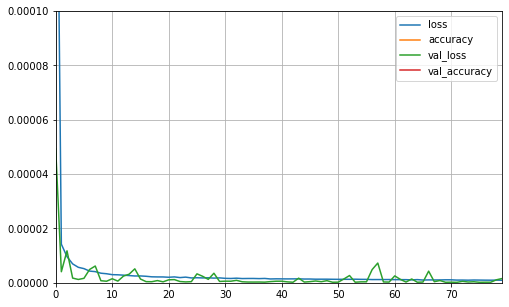

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
myPd = pd.DataFrame(history.history)

myPd.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.0001) # set the vertical range to [0-1]
plt.show()

In [34]:
RBFhistory = myRBFmodel.fit(X_train, y_train, epochs = 80, batch_size = 512, validation_data=(X_valid, y_valid))

Epoch 1/80
3516/3516 [==============================] - 104s 30ms/step - loss: 0.0013 - accuracy: 0.0148 - val_loss: 1.8564e-04 - val_accuracy: 0.0148
Epoch 2/80
3516/3516 [==============================] - 91s 26ms/step - loss: 1.3223e-04 - accuracy: 0.0148 - val_loss: 1.9598e-04 - val_accuracy: 0.0148
Epoch 3/80
3516/3516 [==============================] - 90s 26ms/step - loss: 9.8429e-05 - accuracy: 0.0148 - val_loss: 2.7350e-05 - val_accuracy: 0.0148
Epoch 4/80
3516/3516 [==============================] - 93s 26ms/step - loss: 7.7526e-05 - accuracy: 0.0148 - val_loss: 2.3971e-05 - val_accuracy: 0.0148
Epoch 5/80
3516/3516 [==============================] - 89s 25ms/step - loss: 6.2511e-05 - accuracy: 0.0148 - val_loss: 6.5692e-05 - val_accuracy: 0.0148
Epoch 6/80
3516/3516 [==============================] - 89s 25ms/step - loss: 5.2837e-05 - accuracy: 0.0148 - val_loss: 5.6968e-05 - val_accuracy: 0.0148
Epoch 7/80
3516/3516 [==============================] - 88s 25ms/step - loss: 4

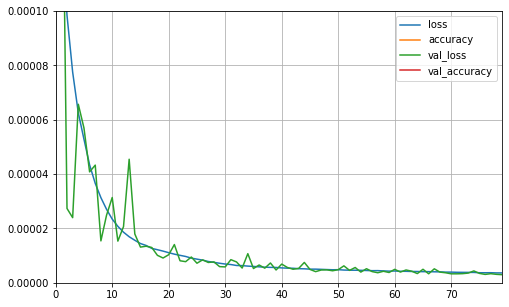

In [35]:
myRBFPd = pd.DataFrame(RBFhistory.history)

myRBFPd.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.0001) # set the vertical range to [0-1]
plt.show()

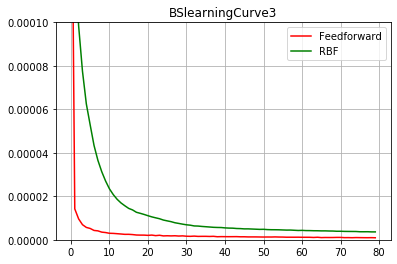

In [36]:
plt.plot(myPd["loss"], "r", label = "Feedforward")
#plt.plot(pd1["val_loss"], "b")
plt.plot(myRBFPd["loss"], "g", label = "RBF")

plt.grid(True)
plt.gca().set_ylim(0, 0.0001)
plt.legend(loc = "upper right")
plt.title('BSlearningCurve3')
plt.show()

In [37]:
mymodel1.save("mymodel1.h5")
myRBFmodel.save("myRBFmodel.h5")

In [5]:
keras.models.load_model("myRBFmodel.h5", custom_objects={'CustomLayer': RBFLayer})

ValueError: Unknown layer: RBFLayer

In [13]:
# ###################### TEST #############################

In [37]:
pd_BS = pd.read_csv(r'C:\Users\Γιώργος\Desktop\THESIS\PYTHON\DATA\BsTest.csv')
X = pd_BS.to_numpy()

inputs_BS = np.array(X[:,:4])
outputs_BS = np.array(X[:,4])
pd_BS.head()

,mns,tau,r,sigma,V/K
0,1.590163,0.888092,0.054842,0.262597,0.639821
1,1.385022,0.959522,0.082605,0.165499,0.461592
2,0.436090,0.415409,0.021017,0.417887,0.000056
3,0.897337,0.386878,0.092519,0.675848,0.123521
4,0.678262,0.947873,0.096074,0.157999,0.001229


In [38]:
FF_Test  = mymodel1.evaluate(inputs_BS,outputs_BS)


6250/6250 [==============================] - 10s 2ms/step - loss: 1.5741e-06 - accuracy: 0.0148


In [24]:
pd_IV = pd.read_csv(r'C:\Users\Γιώργος\Desktop\THESIS\PYTHON\DATA\IvTest.csv')
X = pd_IV.to_numpy()

inputs_IV = np.array(X[:,:4])
outputs_IV = np.array(X[:,4])
pd_IV.head()

,mns,tau,r,sigma,V/K
0,1.392623,0.776319,0.043553,0.436368,0.436368
1,1.238767,0.851717,0.078256,0.308680,0.308680
2,0.527068,0.277376,0.001272,0.000149,0.000149
3,0.873002,0.247260,0.090648,0.080202,0.080202
4,0.708696,0.839421,0.095092,0.004126,0.004126


In [39]:
RBF_Test = myRBFmodel.evaluate(inputs_BS,outputs_BS)  
FF_Test  = mymodel1.evaluate(inputs_BS,outputs_BS)
print("mean square error from RBF network :", RBF_Test[0])
print("mean square error from feedforward network:", FF_Test[0])

6250/6250 [==============================] - 9s 1ms/step - loss: 1.5741e-06 - accuracy: 0.0148
mean square error from RBF network : 3.048828602914e-06
mean square error from feedforward network: 1.5741446759420796e-06


In [42]:
##########################################
###ERROR ANALYSIS!
##########################################
from tensorflow.keras import metrics

In [40]:
RBFresults = myRBFmodel.predict(inputs_BS)
model1results = mymodel1.predict(inputs_BS)


In [45]:
m1 = metrics.MeanAbsoluteError()
m1.update_state(RBFresults, outputs_BS)

m1.result().numpy()

0.00091884873

In [46]:
m1 = metrics.MeanAbsoluteError()
m1.update_state(model1results, outputs_BS)

m1.result().numpy()

0.0010261238

In [47]:
np.sqrt(3.0488e-06)

0.0017460813268573717

In [48]:
def PEX_metrics(y_true, y_pred, X):
    K = 0
    n = len(y_true)
    for i in range(n):
        if(np.abs(y_true[i] - y_pred[i])<= X/100):
            K = K+1
    results = K/n *100
    return(results)

In [49]:
PEX_metrics(model1results, outputs_BS,0.1)

50.4915

In [50]:
PEX_metrics(model1results, outputs_BS,0.05)

29.308

In [51]:
PEX_metrics(RBFresults, outputs_BS,0.1)

76.541

99.99900000000001